In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

path = 'Salary_Data.csv'

df = pd.read_csv(path)
df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


# Data Cleaning

In [2]:
df['Education Level'].value_counts()

Education Level
Bachelor's Degree    2267
Master's Degree      1573
PhD                  1368
Bachelor's            756
High School           448
Master's              288
phD                     1
Name: count, dtype: int64

In [3]:
print(df.columns)
print(type(df.Salary[0]))
print(type(df['Years of Experience'][0]))

Index(['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience',
       'Salary'],
      dtype='object')
<class 'numpy.float64'>
<class 'numpy.float64'>


In [4]:
# Combining the education level Bachelor's degree and Bachelor's
df['Education Level'] = df['Education Level'].replace("Bachelor's Degree", "Bachelor's")
df['Education Level'] = df['Education Level'].replace("phD", "PhD")
df['Education Level'] = df['Education Level'].replace("Master's Degree", "Master's")

df['Education Level'].value_counts()

Education Level
Bachelor's     3023
Master's       1861
PhD            1369
High School     448
Name: count, dtype: int64

Text(0, 0.5, 'Salary')

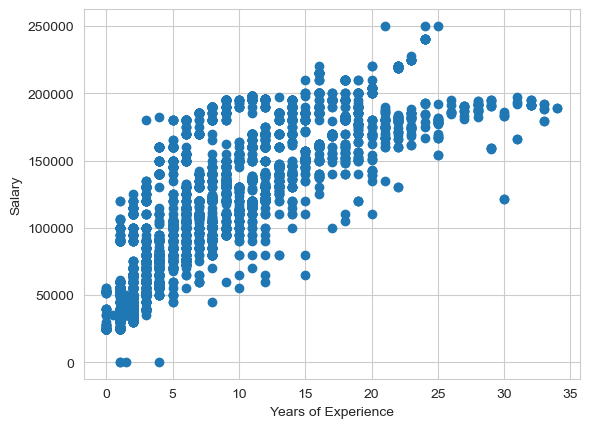

In [5]:
plt.scatter(df['Years of Experience'], df['Salary'])
plt.xlabel('Years of Experience')
plt.ylabel('Salary')

/var/folders/v9/n514v4yd4hn8vqwrpj4cdt8c0000gn/T/ipykernel_26482/551786710.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('Education Level')['Salary'].mean().plot(kind='bar')


<Axes: xlabel='Education Level'>

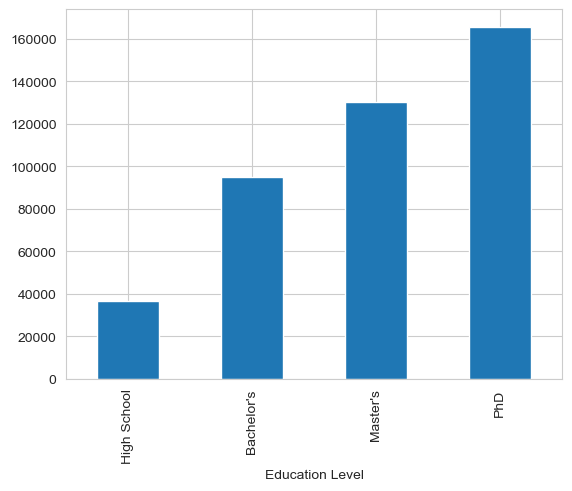

In [6]:
df['Education Level'] = pd.Categorical(df['Education Level'], categories=['High School', 'Bachelor\'s', 'Master\'s', 'PhD'], ordered=True)

df.groupby('Education Level')['Salary'].mean().plot(kind='bar')

In [7]:
# Job Title with the most data
df['Job Title'].value_counts()

Job Title
Software Engineer             518
Data Scientist                453
Software Engineer Manager     376
Data Analyst                  363
Senior Project Engineer       318
                             ... 
Account Manager                 1
Help Desk Analyst               1
Senior Training Specialist      1
Junior Web Designer             1
Supply Chain Analyst            1
Name: count, Length: 193, dtype: int64

In [8]:
# Remove Jobs with less than 10 data points
df = df.groupby('Job Title').filter(lambda x: len(x) > 100)
df['Job Title'].value_counts()

Job Title
Software Engineer            518
Data Scientist               453
Software Engineer Manager    376
Data Analyst                 363
Senior Project Engineer      318
Product Manager              313
Full Stack Engineer          309
Marketing Manager            255
Senior Software Engineer     244
Back end Developer           244
Front end Developer          241
Marketing Coordinator        158
Junior Sales Associate       142
Financial Manager            134
Marketing Analyst            132
Software Developer           125
Operations Manager           114
Human Resources Manager      104
Name: count, dtype: int64

# Define Model

In [9]:
import torch.nn as nn
class RegressionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RegressionModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.activation1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_dim, output_dim)
        # self.activation2 = nn.ReLU()
        # self.layer3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.activation1(x)
        x = self.layer2(x)
        # x = self.activation2(x)
        # return self.layer3(x)
        return x

# Prepare data

In [14]:
# Encode 'Education Level' for simplicity
education_mapping = {'High School': 0, 'Bachelor\'s': 1, 'Master\'s': 2, 'PhD': 3}
df['Education Level'] = df['Education Level'].map(lambda x: education_mapping.get(x, x)).copy()

df = df[df['Gender'] != 'Other']
gender_mapping = {'Male': 0, 'Female': 1}
df['Gender'] = df['Gender'].map(lambda x: gender_mapping.get(x, x)).copy()

train, test = train_test_split(df, test_size=0.3, random_state=42)
train, val = train_test_split(train, test_size=0.11, random_state=42)

target_column = "Salary"
sensitive_feature = ['Age', 'Gender']
features = train.columns.difference([target_column])

scaler = StandardScaler()

train[['Years of Experience', 'Salary', 'Age']] = scaler.fit_transform(train[['Years of Experience', 'Salary', 'Age']])
val[['Years of Experience', 'Salary', 'Age']] = scaler.transform(val[['Years of Experience', 'Salary', 'Age']])
test[['Years of Experience', 'Salary', 'Age']] = scaler.transform(test[['Years of Experience', 'Salary', 'Age']])

encoder = LabelEncoder()
train['Job Title'] = encoder.fit_transform(train['Job Title'])
val['Job Title'] = encoder.transform(val['Job Title'])
test['Job Title'] = encoder.transform(test['Job Title'])

X_train = pd.DataFrame((train),columns = features)
y_train = pd.DataFrame((train),columns = [target_column])
# X_train = torch.tensor(train[features].values, dtype=torch.float32)
# y_train = torch.tensor(train[target_column].values, dtype=torch.float32).view(-1, 1)
X_val = pd.DataFrame((val),columns = features)
y_val = pd.DataFrame((val),columns = [target_column])
# X_val = torch.tensor(val[features].values, dtype=torch.float32)
# y_val = torch.tensor(val[target_column].values, dtype=torch.float32).view(-1, 1)
X_test = pd.DataFrame((test),columns = features)
y_test = pd.DataFrame((test),columns = [target_column])
# X_test = torch.tensor(test[features].values, dtype=torch.float32)
# y_test = torch.tensor(test[target_column].values, dtype=torch.float32).view(-1, 1)

In [15]:
X_train

,Age,Education Level,Gender,Job Title,Years of Experience
3839,0.648389,2,1,6,0.408237
4032,1.161282,3,0,2,1.219705
2910,1.545952,2,0,14,1.868880
2364,-1.274961,1,1,15,-1.052406
5138,0.391942,1,0,12,0.570530
...,...,...,...,...,...
2414,-1.403184,3,0,17,-1.214700
846,-1.018514,1,0,1,-0.890113
1717,0.648389,2,1,14,0.408237
4015,-0.890291,2,1,10,-0.890113


In [19]:
y_train

,Salary
3839,-0.099059
4032,0.716454
2910,1.021007
2364,-1.424266
5138,0.512576
...,...
2414,-0.102402
846,0.104820
1717,0.716454
4015,-1.322327


# Training For Data Scientist Job not important for prediction

In [16]:
selected_features = ['Years of Experience', 'Education Level']
model_all = MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=1000)
model_all.fit(X_train[selected_features], y_train)

y_pred = model_all.predict(X_test[selected_features])
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Inverse transform predictions back to original salary scale
y_test_pred_unscaled = scaler.inverse_transform(
    np.concatenate((X_test[['Years of Experience']].values, y_pred.reshape(-1, 1), X_test[['Age']].values), axis=1))[:, 1]

sum_error_all = 0

for i, pred in enumerate(y_test_pred_unscaled):
    actual_salary = scaler.inverse_transform(test[['Years of Experience', 'Salary', 'Age']].values)[i][1]
    sum_error_all += abs(pred - actual_salary)/ len(y_test_pred_unscaled)
    
print(f"Average Error: {sum_error_all}")

ValueError: Input y contains NaN.

In [114]:
# Set up model parameters
selected_features = ['Years of Experience', 'Education Level']

input_dim = 2  # Years of Experience, Education Level, 
hidden_dim = 64
output_dim = 1
model_all = RegressionModel(input_dim, hidden_dim, output_dim)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_all.parameters(), lr=0.001, weight_decay=1e-4)  # Add weight decay for L2 regularization

# Training loop
train_losses, val_losses = [], []
for epoch in range(5000):
    model_all.train()
    optimizer.zero_grad()
    y_pred = model_all(X_train[selected_features])
    train_loss = criterion(y_pred, y_train)
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())
    
    # Validation loss
    model_all.eval()
    with torch.no_grad():
        y_val_pred = model_all(X_val[selected_features])
        val_loss = criterion(y_val_pred, y_val)
        val_losses.append(val_loss.item())
        
    # Print progress every 100 epochs
    if epoch % 1000 == 0:
        print(f'Epoch {epoch} - Train Loss: {train_loss.item()} | Validation Loss: {val_loss.item()}')

# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on test set
model_all.eval()
with torch.no_grad():
    y_test_pred = model_all(X_test[selected_features])
    test_loss = criterion(y_test_pred, y_test)
    print(f'Test Loss: {test_loss.item()}')

TypeError: linear(): argument 'input' (position 1) must be Tensor, not DataFrame

# Including Gender & Age

Epoch 0 - Train Loss: 1.379032015800476 | Validation Loss: 1.4292322397232056
Epoch 1000 - Train Loss: 0.19534023106098175 | Validation Loss: 0.19953188300132751
Epoch 2000 - Train Loss: 0.17795580625534058 | Validation Loss: 0.18457655608654022
Epoch 3000 - Train Loss: 0.17083053290843964 | Validation Loss: 0.17730756103992462
Epoch 4000 - Train Loss: 0.16644029319286346 | Validation Loss: 0.17387080192565918


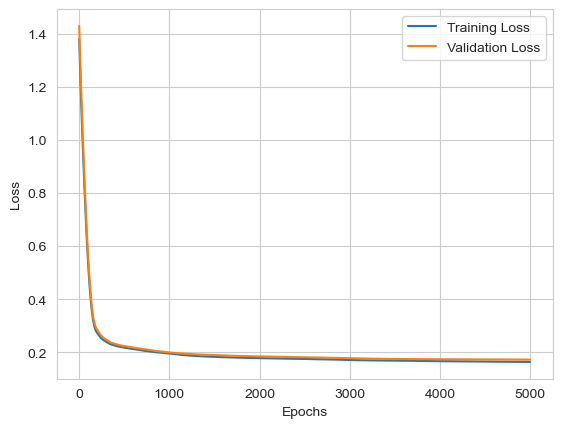

Test Loss: 0.18119549751281738
Average Error: 16990.12385718359


In [10]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Drop rows with missing values in the relevant columns
df_drop2 = df.dropna(subset=['Salary', 'Years of Experience', 'Education Level', 'Gender', 'Age']).copy()

# Check for NaN or infinite values
assert not train.isnull().values.any(), "Training data contains NaN values"
assert not val.isnull().values.any(), "Validation data contains NaN values"
assert not test.isnull().values.any(), "Test data contains NaN values"
assert np.isfinite(train[['Years of Experience', 'Salary', 'Age']].values).all(), "Training data contains infinite values"
assert np.isfinite(val[['Years of Experience', 'Salary', 'Age']].values).all(), "Validation data contains infinite values"
assert np.isfinite(test[['Years of Experience', 'Salary', 'Age']].values).all(), "Test data contains infinite values"


# Set up model parameters
input_dim = 4  # Years of Experience, Education Level, Gender, Age
hidden_dim = 20
output_dim = 1
model_all_gen_age = RegressionModel(input_dim, hidden_dim, output_dim)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_all_gen_age.parameters(), lr=0.001, weight_decay=1e-4)  # Add weight decay for L2 regularization

# Prepare data for PyTorch
X_train = torch.tensor(train[['Years of Experience', 'Education Level', 'Gender', 'Age']].values, dtype=torch.float32)
y_train = torch.tensor(train['Salary'].values, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(val[['Years of Experience', 'Education Level', 'Gender', 'Age']].values, dtype=torch.float32)
y_val = torch.tensor(val['Salary'].values, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(test[['Years of Experience', 'Education Level', 'Gender', 'Age']].values, dtype=torch.float32)
y_test = torch.tensor(test['Salary'].values, dtype=torch.float32).view(-1, 1)

# Training loop
train_losses, val_losses = [], []
for epoch in range(5000):
    model_all_gen_age.train()
    optimizer.zero_grad()
    y_pred = model_all_gen_age(X_train)
    train_loss = criterion(y_pred, y_train)
    if torch.isnan(train_loss):
        print(f"NaN detected in train loss at epoch {epoch}")
        break
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())

    # Validation loss
    model_all_gen_age.eval()
    with torch.no_grad():
        y_val_pred = model_all_gen_age(X_val)
        val_loss = criterion(y_val_pred, y_val)
        if torch.isnan(val_loss):
            print(f"NaN detected in validation loss at epoch {epoch}")
            break
        val_losses.append(val_loss.item())

    # Print progress every 100 epochs
    if epoch % 1000 == 0:
        print(f'Epoch {epoch} - Train Loss: {train_loss.item()} | Validation Loss: {val_loss.item()}')

# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on test set
model_all_gen_age.eval()
with torch.no_grad():
    y_test_pred = model_all_gen_age(X_test)
    test_loss = criterion(y_test_pred, y_test)
    print(f'Test Loss: {test_loss.item()}')

# Inverse transform predictions back to original salary scale
# We add placeholders for 'Years of Experience' and 'Age' to inverse transform correctly
y_test_pred_unscaled = scaler.inverse_transform(
    torch.cat((X_test[:, 0].unsqueeze(1), y_test_pred, X_test[:, 1:2]), dim=1))[:, 1]

sum_error_all_ga = 0
for i, pred in enumerate(y_test_pred_unscaled):
    actual_salary = scaler.inverse_transform(test[['Years of Experience', 'Salary', 'Age']].values)[i][1]
    sum_error_all_ga += abs(pred - actual_salary)/ len(y_test_pred_unscaled)

print(f"Average Error: {sum_error_all_ga}")

Test loss 0.18

# Training For Software Engineer

Epoch 0 - Train Loss: 1.3794965744018555 | Validation Loss: 1.5881664752960205
Epoch 1000 - Train Loss: 0.302364319562912 | Validation Loss: 0.303560346364975
Epoch 2000 - Train Loss: 0.2994595468044281 | Validation Loss: 0.30112147331237793
Epoch 3000 - Train Loss: 0.2992347180843353 | Validation Loss: 0.3013468086719513
Epoch 4000 - Train Loss: 0.29921016097068787 | Validation Loss: 0.3013891577720642
Epoch 5000 - Train Loss: 0.2991848886013031 | Validation Loss: 0.3014591634273529
Epoch 6000 - Train Loss: 0.299171507358551 | Validation Loss: 0.3015175759792328
Epoch 7000 - Train Loss: 0.2991482615470886 | Validation Loss: 0.3015825152397156
Epoch 8000 - Train Loss: 0.2991430163383484 | Validation Loss: 0.3016588091850281
Epoch 9000 - Train Loss: 0.2991487383842468 | Validation Loss: 0.3017168641090393


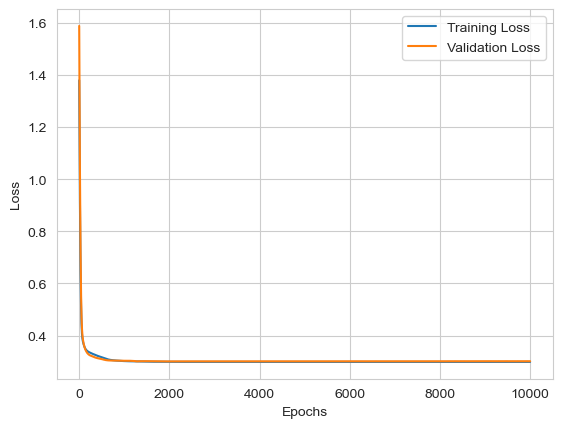

Test Loss: 0.2958328425884247
Average Error: 19575.577307914948


In [11]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Filter data for a specific job title
job = 'Software Engineer'
df_job = df[df['Job Title'] == job]
df_job = df_job.dropna(subset=['Salary', 'Years of Experience', 'Education Level']).copy()

# Encode 'Education Level' for simplicity
education_mapping = {'High School': 0, 'Bachelor\'s': 1, 'Master\'s': 2, 'PhD': 3}
df_job['Education Level'] = df_job['Education Level'].map(education_mapping).copy()

# Split the data
train, test = train_test_split(df_job, test_size=0.3, random_state=42)
train, val = train_test_split(train, test_size=0.11, random_state=42)

# Scale 'Years of Experience' and 'Salary' for stability
scaler = StandardScaler()
train[['Years of Experience', 'Salary']] = scaler.fit_transform(train[['Years of Experience', 'Salary']])
val[['Years of Experience', 'Salary']] = scaler.transform(val[['Years of Experience', 'Salary']])
test[['Years of Experience', 'Salary']] = scaler.transform(test[['Years of Experience', 'Salary']])

# Set up model parameters
input_dim = 2  # Years of Experience, Education Level
hidden_dim = 64
output_dim = 1
model_SE = RegressionModel(input_dim, hidden_dim, output_dim)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_SE.parameters(), lr=0.001, weight_decay=1e-4)  # Add weight decay for L2 regularization

# Prepare data for PyTorch
X_train = torch.tensor(train[['Years of Experience', 'Education Level']].values, dtype=torch.float32)
y_train = torch.tensor(train['Salary'].values, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(val[['Years of Experience', 'Education Level']].values, dtype=torch.float32)
y_val = torch.tensor(val['Salary'].values, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(test[['Years of Experience', 'Education Level']].values, dtype=torch.float32)
y_test = torch.tensor(test['Salary'].values, dtype=torch.float32).view(-1, 1)

# Training loop
train_losses, val_losses = [], []
for epoch in range(10000):
    model_SE.train()
    optimizer.zero_grad()
    y_pred = model_SE(X_train)
    train_loss = criterion(y_pred, y_train)
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())
    
    # Validation loss
    model_SE.eval()
    with torch.no_grad():
        y_val_pred = model_SE(X_val)
        val_loss = criterion(y_val_pred, y_val)
        val_losses.append(val_loss.item())
        
    # Print progress every 100 epochs
    if epoch % 1000 == 0:
        print(f'Epoch {epoch} - Train Loss: {train_loss.item()} | Validation Loss: {val_loss.item()}')

# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on test set
model_SE.eval()
with torch.no_grad():
    y_test_pred = model_SE(X_test)
    test_loss = criterion(y_test_pred, y_test)
    print(f'Test Loss: {test_loss.item()}')

# Inverse transform predictions back to original salary scale
y_test_pred_unscaled = scaler.inverse_transform(
    torch.cat((X_test[:, 0].unsqueeze(1), y_test_pred), dim=1))[:, 1]

sum_error_SE = 0
for i, pred in enumerate(y_test_pred_unscaled):
    actual_salary = scaler.inverse_transform(test[['Years of Experience', 'Salary']].values)[i][1]
    sum_error_SE += abs(pred - actual_salary)/ len(y_test_pred_unscaled)
    
print(f"Average Error: {sum_error_SE}")

# Including Gender & Age

Epoch 0 - Train Loss: 1.0499612092971802 | Validation Loss: 1.230268955230713
Epoch 1000 - Train Loss: 0.1511623114347458 | Validation Loss: 0.13425981998443604
Epoch 2000 - Train Loss: 0.09814636409282684 | Validation Loss: 0.10661114752292633
Epoch 3000 - Train Loss: 0.0747813805937767 | Validation Loss: 0.09356681257486343
Epoch 4000 - Train Loss: 0.0579717755317688 | Validation Loss: 0.07097691297531128
Epoch 5000 - Train Loss: 0.05205010995268822 | Validation Loss: 0.06428985297679901
Epoch 6000 - Train Loss: 0.05099516361951828 | Validation Loss: 0.06416025012731552
Epoch 7000 - Train Loss: 0.0504925474524498 | Validation Loss: 0.06399983167648315
Epoch 8000 - Train Loss: 0.050176940858364105 | Validation Loss: 0.06320758908987045
Epoch 9000 - Train Loss: 0.049958568066358566 | Validation Loss: 0.06258706748485565


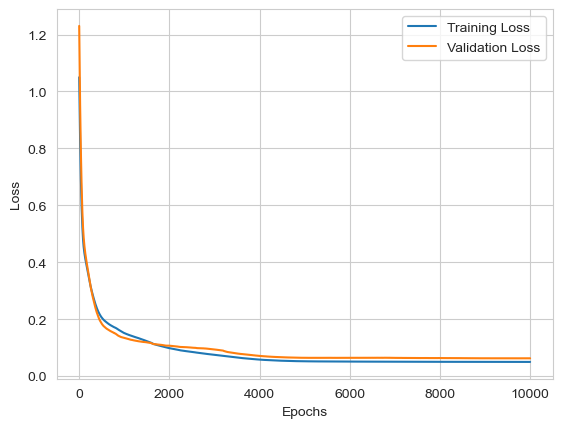

Test Loss: 0.09220155328512192
Average Error: 6343.834284132192


In [12]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Filter data for a specific job title
job = 'Software Engineer'
df_job = df[df['Job Title'] == job]
df_job = df_job.dropna(subset=['Salary', 'Years of Experience', 'Education Level', 'Gender', 'Age']).copy()

# Encode 'Education Level' for simplicity
education_mapping = {'High School': 0, 'Bachelor\'s': 1, 'Master\'s': 2, 'PhD': 3}
df_job['Education Level'] = df_job['Education Level'].map(education_mapping).copy()

# Encode 'Gender'
gender_mapping = {'Male': 0, 'Female': 1}
df_job['Gender'] = df_job['Gender'].map(gender_mapping).copy()

# Split the data
train, test = train_test_split(df_job, test_size=0.3, random_state=42)
train, val = train_test_split(train, test_size=0.11, random_state=42)

# Scale 'Years of Experience', 'Age', and 'Salary' for stability
scaler = StandardScaler()
train[['Years of Experience', 'Salary', 'Age']] = scaler.fit_transform(train[['Years of Experience', 'Salary', 'Age']])
val[['Years of Experience', 'Salary', 'Age']] = scaler.transform(val[['Years of Experience', 'Salary', 'Age']])
test[['Years of Experience', 'Salary', 'Age']] = scaler.transform(test[['Years of Experience', 'Salary', 'Age']])

# Set up model parameters
input_dim = 4  # Years of Experience, Education Level, Gender, Age
hidden_dim = 20
output_dim = 1
model_SE_gen_age = RegressionModel(input_dim, hidden_dim, output_dim)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_SE_gen_age.parameters(), lr=0.001, weight_decay=1e-4)  # Add weight decay for L2 regularization

# Prepare data for PyTorch
X_train = torch.tensor(train[['Years of Experience', 'Education Level', 'Gender', 'Age']].values, dtype=torch.float32)
y_train = torch.tensor(train['Salary'].values, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(val[['Years of Experience', 'Education Level', 'Gender', 'Age']].values, dtype=torch.float32)
y_val = torch.tensor(val['Salary'].values, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(test[['Years of Experience', 'Education Level', 'Gender', 'Age']].values, dtype=torch.float32)
y_test = torch.tensor(test['Salary'].values, dtype=torch.float32).view(-1, 1)

# Training loop
train_losses, val_losses = [], []
for epoch in range(10000):
    model_SE_gen_age.train()
    optimizer.zero_grad()
    y_pred = model_SE_gen_age(X_train)
    train_loss = criterion(y_pred, y_train)
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())
    
    # Validation loss
    model_SE_gen_age.eval()
    with torch.no_grad():
        y_val_pred = model_SE_gen_age(X_val)
        val_loss = criterion(y_val_pred, y_val)
        val_losses.append(val_loss.item())
        
    # Print progress every 100 epochs
    if epoch % 1000 == 0:
        print(f'Epoch {epoch} - Train Loss: {train_loss.item()} | Validation Loss: {val_loss.item()}')

# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on test set
model_SE_gen_age.eval()
with torch.no_grad():
    y_test_pred = model_SE_gen_age(X_test)
    test_loss = criterion(y_test_pred, y_test)
    print(f'Test Loss: {test_loss.item()}')

# Inverse transform predictions back to original salary scale
# We add placeholders for 'Years of Experience' and 'Age' to inverse transform correctly
y_test_pred_unscaled = scaler.inverse_transform(
    torch.cat((X_test[:, 0].unsqueeze(1), y_test_pred, X_test[:, 1:2]), dim=1))[:, 1]

sum_error_SE_ga = 0
for i, pred in enumerate(y_test_pred_unscaled):
    actual_salary = scaler.inverse_transform(test[['Years of Experience', 'Salary', 'Age']].values)[i][1]
    sum_error_SE_ga += abs(pred - actual_salary)/ len(y_test_pred_unscaled)
    
print(f"Average Error: {sum_error_SE_ga}")

## Define Feature importance ALL JOBS

In [13]:
df

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0
...,...,...,...,...,...,...
6699,49.0,Female,PhD,Director of Marketing,20.0,200000.0
6700,32.0,Male,High School,Sales Associate,3.0,50000.0
6701,30.0,Female,Bachelor's,Financial Manager,4.0,55000.0
6702,46.0,Male,Master's,Marketing Manager,14.0,140000.0


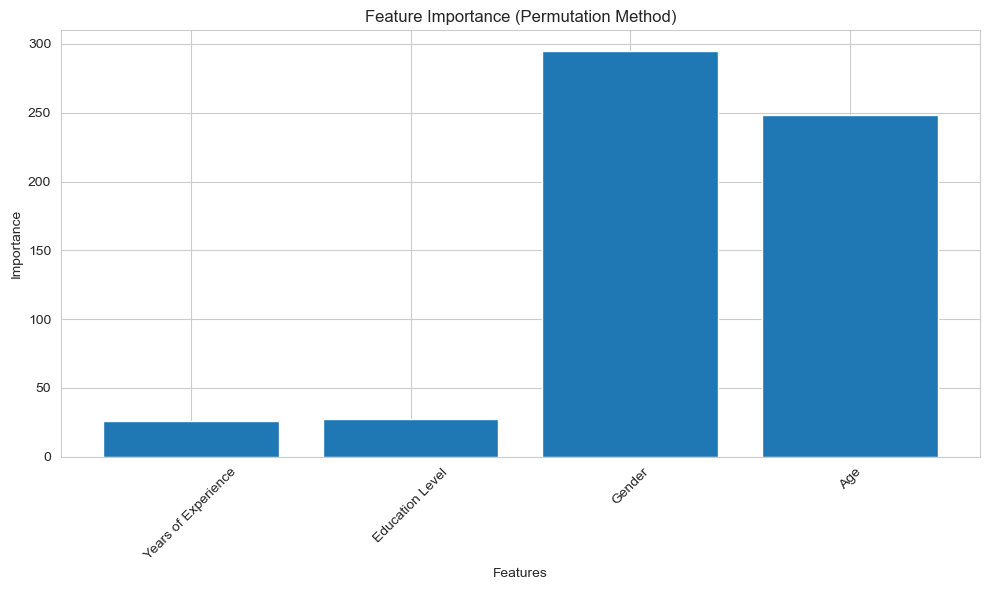

Years of Experience: 25.7879
Education Level: 26.9511
Gender: 295.1234
Age: 248.4028


In [14]:
import numpy as np
from sklearn.metrics import mean_squared_error

def permutation_importance(model, X, y, n_repeats=10):
    baseline_mse = mean_squared_error(y, model(X).detach().numpy())
    importances = []
    
    for col in range(X.shape[1]):
        feature_importances = []
        for _ in range(n_repeats):
            X_permuted = X.clone()
            X_permuted[:, col] = torch.randperm(X.shape[0])
            permuted_mse = mean_squared_error(y, model(X_permuted).detach().numpy())
            importance = permuted_mse - baseline_mse
            feature_importances.append(importance)
        importances.append(np.mean(feature_importances))
    
    return np.array(importances)

# Calculate permutation importance
feature_names = ['Years of Experience', 'Education Level', 'Gender', 'Age']
importances = permutation_importance(model_all_gen_age, X_test, y_test)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_names, importances)
plt.title('Feature Importance (Permutation Method)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print feature importances
for name, importance in zip(feature_names, importances):
    print(f"{name}: {importance:.4f}")

It's important to note that these values represent the increase in the model's error when the feature is permuted. A larger increase in error indicates that the feature is more important for the model's predictions

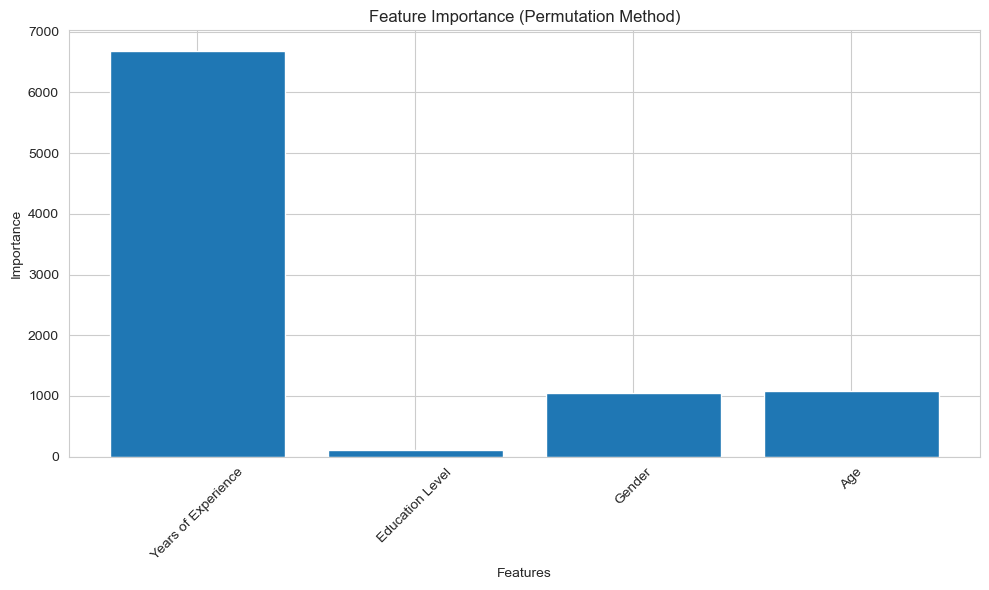

Years of Experience: 6688.0664
Education Level: 104.8970
Gender: 1043.1041
Age: 1082.1984


In [15]:
# Calculate permutation importance
feature_names = ['Years of Experience', 'Education Level', 'Gender', 'Age']
importances = permutation_importance(model_SE_gen_age, X_test, y_test)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_names, importances)
plt.title('Feature Importance (Permutation Method)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print feature importances
for name, importance in zip(feature_names, importances):
    print(f"{name}: {importance:.4f}")

# Fairness

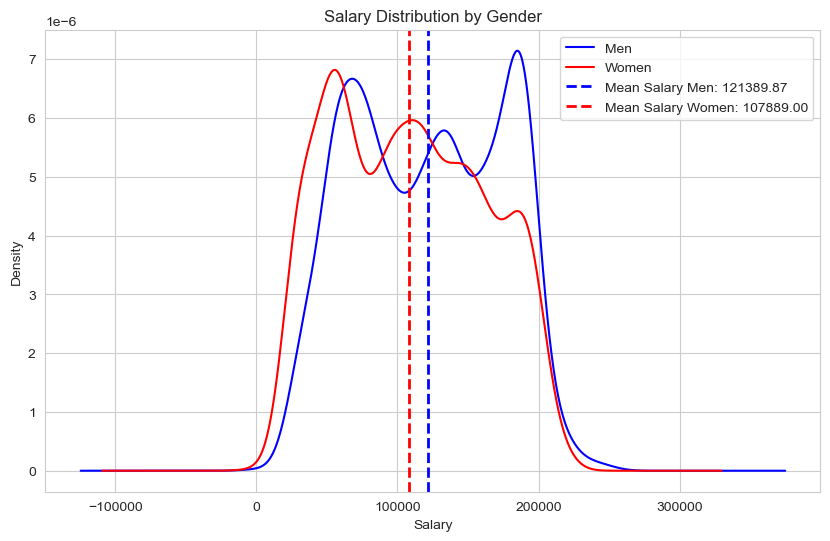

In [16]:
df = df[df['Gender'] != 'Other']
df['Gender'].value_counts()

# Separate the data by gender
salaries_men = df[df['Gender'] == 'Male']['Salary']
salaries_women = df[df['Gender'] == 'Female']['Salary']

# Calculate the mean salaries
mean_salary_men = salaries_men.mean()
mean_salary_women = salaries_women.mean()

# Create the plot
plt.figure(figsize=(10, 6))
salaries_men.plot(kind='density', label='Men', color='blue')
salaries_women.plot(kind='density', label='Women', color='red')

# Add vertical lines for the mean salaries
plt.axvline(mean_salary_men, color='blue', linestyle='dashed', linewidth=2, label=f'Mean Salary Men: {mean_salary_men:.2f}')
plt.axvline(mean_salary_women, color='red', linestyle='dashed', linewidth=2, label=f'Mean Salary Women: {mean_salary_women:.2f}')

plt.title('Salary Distribution by Gender')
plt.xlabel('Salary')
plt.ylabel('Density')
plt.legend()
plt.show()

Diffrence in mean salary for all jobs

In [20]:
mean_salary_men-mean_salary_women

13500.872242613157

Diffrence in mean salary prediction for all jobs

In [17]:
model_all.predict(df)

2335.3434690502727

# Is Uni worth it?

In [18]:
## The idea is to see if 4 years of experience is worth more than a Bachelor or 6 years more than a Master's or 10 years more than a PhD

model_all

RegressionModel(
  (layer1): Linear(in_features=2, out_features=64, bias=True)
  (activation1): ReLU()
  (layer2): Linear(in_features=64, out_features=1, bias=True)
)